In [1]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]

from utilities import get_tex_label, get_color, latex_text_width_1col
from hazma.parameters import vh
from hazma.gamma_ray_parameters import (energy_res_comptel, energy_res_fermi,
                                        energy_res_e_astrogam, energy_res_egret)
from hazma.scalar_mediator import ScalarMediator, HiggsPortal, HeavyQuark
from hazma.vector_mediator import VectorMediator

**Plots annihilation spectra for the scalar model in the case $m_\chi < m_S$.**

In [2]:
# Dark matter masses
mxs = np.array([100., 110., 140., 250.])
# Mediator mass
ms = 1e3
# Make array of models. The top row of the plot will contain the Higgs
# portal model spectra, the bottom the heavy quark model spectra.
sms = np.array([[HiggsPortal(mx, ms, gsxx=1., stheta=1e-1)
                 for mx in mxs],
                [HeavyQuark(mx, ms, gsxx=1., gsQ=1e-1, mQ=1e3, QQ=1.)
                 for mx in mxs]])

# Approximate Milky Way velocity dispersion, used to compute the DM
# center of mass energy
vx_mw = 1e-3

# Photon energies
e_gam_min, e_gam_max = 5., 300.
e_gams = np.geomspace(e_gam_min, e_gam_max, 250)

# Plot dimensions
n_subplot_rows, n_subplot_cols = len(sms), len(mxs)
# Final state labels for each subplot
fs_labels = np.array([[{"e e": (1.5e1, 4e-3)}, {"mu mu": (1.5e1, 3e-3)},
                       {"pi pi": (7e0, 4e-3), "pi0 pi0": (4.5e1, 9e-2)}, {}],
                      [{}, {},
                       {"pi pi": (7e0, 4e-3), "pi0 pi0": (4.5e1, 1.1e-1)}, {}]])

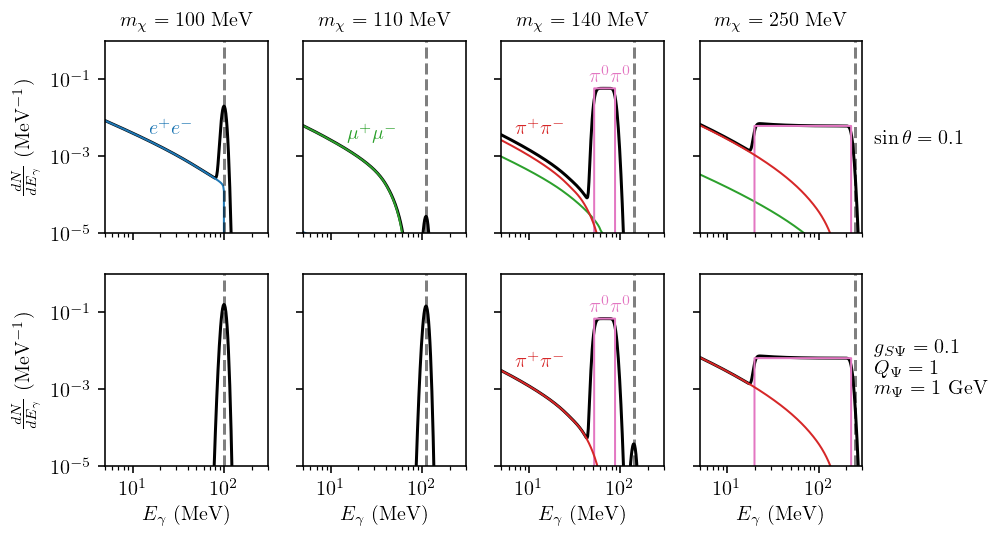

In [4]:
fig, axes = plt.subplots(
    n_subplot_rows, n_subplot_cols, sharex=True, sharey=True,
    figsize=(latex_text_width_1col, 0.55*latex_text_width_1col))

for row in range(n_subplot_rows):  # loop over type of model
    for col in range(n_subplot_cols):  # loop over DM masses
        ax = axes[row, col]
        
        # Get the model
        sm = sms[row, col]
        # DM center of mass energy
        e_cm = 2.*sm.mx * (1. + 0.5 * vx_mw**2)
        
        # Get function to compute total convolved spectrum
        dnde_det_fn = sm.get_detected_spectrum_function(
            e_gam_min, e_gam_max, e_cm, energy_res=energy_res_comptel)
        # Evaluate and plot
        ax.loglog(e_gams, dnde_det_fn(e_gams), 'k')

        # Plot individual channels' continuum spectra
        for fs, spec in sm.spectra(e_gams, e_cm).items():
            if fs != "total":
                ax.loglog(e_gams, spec, color=get_color(fs), linewidth=1)

        # Compute line energies
        for fs, line_info in sm.gamma_ray_lines(e_cm).items():
            ax.axvline(line_info["energy"], linestyle='--', color='k',
                       alpha=0.5, linewidth=1.5,
                       label=r"$E_{\gamma\gamma}$")

        # Formatting: abel final states
        for fs, (x, y) in fs_labels[row, col].items():
            ax.text(x, y, get_tex_label(fs), fontsize=10, color=get_color(fs))

# Formatting
for row in range(n_subplot_rows):
    axes[row, 0].set_ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
    axes[row, 0].set_ylim(1e-5, 1e0)

for col in range(n_subplot_cols):
    axes[0, col].set_title(r"$m_\chi = %i$ MeV" % mxs[col], fontsize=10)
    axes[-1, col].set_xlabel(r"$E_\gamma$ (MeV)")
    axes[-1, col].set_xlim(e_gam_min, e_gam_max)

axes[0, -1].text(400, 3e-3, r"$\sin\theta = 0.1$", va="center", fontsize=10)
axes[1, -1].text(400, 3e-3, r"$g_{S\Psi} = 0.1$" + "\n" + r"$Q_\Psi = 1$" + "\n" + r"$m_\Psi = 1$ GeV", va="center", fontsize=10)

fig.tight_layout()
fig.savefig("figures/scalar_spectra_ann_to_sm.pdf", bbox_inches="tight")
plt.show()